<a href="https://colab.research.google.com/github/davidokel/MelanomaClassification/blob/main/MelanomaClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification of Melanoma images

# Preamble and data processing

In [1]:
from google.colab import drive
import tensorflow as tf
import tensorflow_datasets as tfds
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import random

AUTO = tf.data.AUTOTUNE

drive.mount('/content/drive')

dir = '/content/drive/MyDrive/MSc AI for Biomedicine and Healthcare/AI for Biomedicine and Healthcare/archive'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
image_size=(512,512)
image_shape = [*image_size, 3]
batch_size = 64

FILENAMES = tf.io.gfile.glob(dir + "/train*.tfrec")
split_ind = int(0.9 * len(FILENAMES))
TRAINING_FILENAMES, VALID_FILENAMES = FILENAMES[:split_ind], FILENAMES[split_ind:]

TEST_FILENAMES = tf.io.gfile.glob(dir + "/test*.tfrec")
print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
print("Test TFRecord Files:", len(TEST_FILENAMES))

tfrec_format = {
    'image'                        : tf.io.FixedLenFeature([], tf.string),
    'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
    'sex'                          : tf.io.FixedLenFeature([], tf.int64),
    'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
    'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
    'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
    'target'                       : tf.io.FixedLenFeature([], tf.int64)
}

unlabelled_tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }

Train TFRecord Files: 13
Validation TFRecord Files: 2
Test TFRecord Files: 16


In [3]:
def read_tfrecord(example, labelled = True):
  if labelled:           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example["image"], example["target"]
  else:
    example = tf.io.parse_single_example(example, unlabelled_tfrec_format)
    return example["image"], example["image_name"]
  return example

def prepare_image(img, img_name, augment=True):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.reshape(img, [*image_size, 3])
    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
                         
    return img, img_name


def get_dataset(filenames, labelled = True, batch = True, filter=None, is_jpeg=False):
  if is_jpeg:
    builder = tfds.ImageFolder(filenames)
    raw_dataset = builder.as_dataset(split=[], shuffle_files=True)
  else:
    raw_dataset = tf.data.TFRecordDataset(filenames)
  raw_dataset = raw_dataset.cache()
  raw_dataset = raw_dataset.shuffle(1024)
  opt = tf.data.Options()
  opt.experimental_deterministic = False
  raw_dataset = raw_dataset.with_options(opt)

  raw_dataset = raw_dataset.map(lambda element: read_tfrecord(element, labelled))
  raw_dataset = raw_dataset.map(lambda img, img_name: prepare_image(img, img_name, False))

  if batch:
    raw_dataset = raw_dataset.batch(batch_size)
  
  return raw_dataset

def show_batch(dataset):
  plt.figure(figsize=(10,10))
  n = 0
  for x,y in dataset.take(9):
    ax = plt.subplot(3,3, n+1)
    plt.imshow(x)
    if y:
        plt.title("MALIGNANT")
    else:
        plt.title("BENIGN")
    plt.axis("off")
    n += 1

In [4]:
def filter_by_target(ds, target):
  filtered = ds.filter(lambda img, label: label == target)
  return filtered

In [5]:
full_training_set = get_dataset(TRAINING_FILENAMES, batch=False)
full_valid_set = get_dataset(VALID_FILENAMES, batch=False)
full_test_set = get_dataset(TEST_FILENAMES, labelled=False, batch=False)

In [6]:
size = 300
pos_ds = filter_by_target(full_training_set, 1)
neg_ds = filter_by_target(full_training_set, 0)

small_training_ds = pos_ds.take(size).concatenate(neg_ds.take(size*2)).shuffle(size*3)
training_set = small_training_ds.take(size)
valid_set = full_valid_set.take(size)
test_set = full_test_set.take(size)

In [6]:
size = 2000
pos_ds = filter_by_target(full_training_set, 1)
neg_ds = filter_by_target(full_training_set, 0)

small_training_ds = pos_ds.take(size).concatenate(neg_ds.take(size*2)).shuffle(size*3)
training_set = small_training_ds.take(size)
valid_set = full_valid_set.take(size)
test_set = full_test_set.take(size)

training_set=training_set.batch(batch_size)
valid_set = valid_set.batch(batch_size)
test_set = test_set.batch(batch_size)

Augmenting Data

In [7]:
def count_bins(ds):
  pos = 0
  neg = 0
  for x,y in ds:
    if y == 0:
      neg += 1
    else:
      pos += 1

  return neg, pos

In [ ]:
neg, pos = count_bins(training_set)
print("Negative: ", neg)
print("Positive: ", pos)

In [126]:
neg_train_ds = filter_by_target(training_set, 0)
pos_train_ds = filter_by_target(training_set, 1)

Negative:  0
Positive:  111


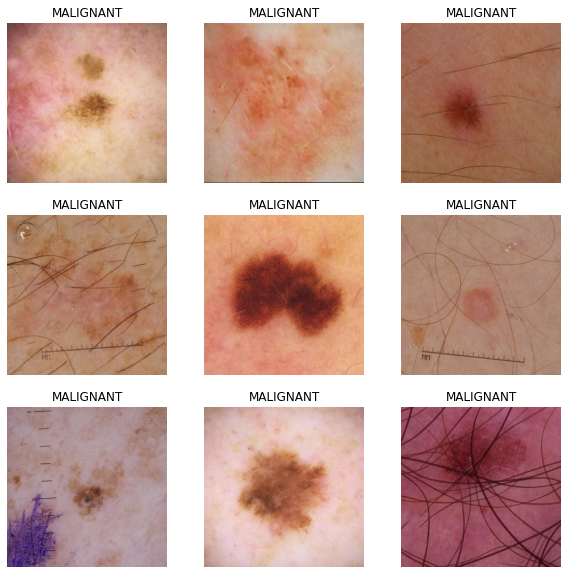

In [127]:
show_batch(pos_train_ds)

In [128]:
trainAug = tf.keras.Sequential([
  # tf.keras.layers.InputLayer(input_shape=)
	tf.keras.layers.RandomFlip(),
  tf.keras.layers.RandomRotation(0.5),
  tf.keras.layers.RandomContrast(0.5),
  tf.keras.layers.RandomZoom(0.2,0.2)
])

trainAug.build(input_shape=image_shape)

trainAug.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_7 (RandomFlip)  (512, 512, 3)             0         
                                                                 
 random_rotation_7 (RandomRo  (512, 512, 3)            0         
 tation)                                                         
                                                                 
 random_contrast_7 (RandomCo  (512, 512, 3)            0         
 ntrast)                                                         
                                                                 
 random_zoom_7 (RandomZoom)  (512, 512, 3)             0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [136]:
aug_pos_ds = pos_train_ds.map(lambda x, y: (trainAug(x), y))
aug_pos_ds = aug_pos_ds.repeat(3)

Negative:  0
Positive:  299


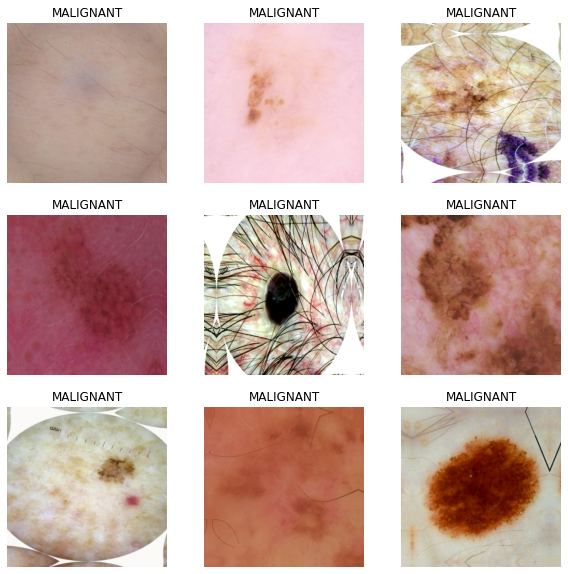

In [137]:
neg, pos = count_bins(aug_pos_ds)
print("Negative: ", neg)
print("Positive: ", pos)
show_batch(aug_pos_ds)

In [139]:
aug_train_ds = aug_pos_ds.concatenate(neg_train_ds)
aug_train_ds = aug_train_ds.shuffle(size)

In [140]:
neg, pos = count_bins(aug_train_ds)
print("Negative: ", neg)
print("Positive: ", pos)

Negative:  196
Positive:  305


In [157]:
training_set = aug_train_ds.batch(batch_size)

Model Building

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input

# create the base pre-trained model on ImageNet with a custom input tensor 
base_model = MobileNet(
    input_shape=image_shape,
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax',)
x = base_model.output
# Add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(8, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
transfer_model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional MobileNet layers, alternatively you can freeze the whole base model without a for loop
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
transfer_model.summary()

In [8]:
LR = 0.001

# compile the model (should be done *after* setting layers to non-trainable)
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives()]
)

In [9]:
class_weight={0:1.0, 1:1.0}

In [10]:
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

NameError: ignored

In [10]:
EPOCHS=5
history = transfer_model.fit(
    training_set, 
    epochs=EPOCHS,
    class_weight=class_weight,
    validation_data=valid_set
)

Epoch 1/5


ValueError: ignored

In [ ]:
model_dir = '/content/drive/MyDrive/MSc AI for Biomedicine and Healthcare/AI for Biomedicine and Healthcare/Models'
transfer_model.save_weights(dir + "/Models")